In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import os
from tqdm import tqdm
import cv2

SEED = 123
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)


In [ ]:

INPUT_SIZE = (256, 256)
MEAN = (0.6181, 0.4643, 0.4194)
STD = (0.1927, 0.1677, 0.1617)

main_data_dir = r""
val_dir = os.path.join(main_data_dir, "val")
test_dir = os.path.join(main_data_dir, "test")

val_dataset = datasets.ImageFolder(root=val_dir)
class_names = list(val_dataset.classes)
print("Class to label mapping:", val_dataset.class_to_idx)


Class to label mapping: {'Acne': 0, 'Eczema': 1, 'Normal': 2, 'Perioral Dermatitis': 3, 'Psoriasis': 4, 'Rosacea': 5, 'Seborrheic Dermatitis': 6, 'Tinea Faciei': 7}


In [3]:
class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        img_np = np.array(img)
        
        if len(img_np.shape) == 3:
            channels = cv2.split(img_np)
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            channels = [clahe.apply(channel) for channel in channels]
            img_np = cv2.merge(channels)
        else:
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            img_np = clahe.apply(img_np)

        img_clahe = Image.fromarray(img_np)
        return img_clahe



In [4]:
transform_val_test = transforms.Compose([
    CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
    transforms.Resize(INPUT_SIZE),
    transforms.CenterCrop((227,227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

val_dataset = datasets.ImageFolder(root=val_dir, transform=transform_val_test)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_val_test)

val_loader = DataLoader(val_dataset, shuffle=False)
test_loader = DataLoader(test_dataset, shuffle=False)


In [ ]:
import torch.nn as nn
import torchvision.models as models


class AlexNet(nn.Module):
    def __init__(self, num_classes=len(class_names)):
        super(AlexNet, self).__init__()
        self.model = models.alexnet(weights=None) 
        self.model.classifier[6] = nn.Linear(4096, num_classes)  

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=len(class_names)).to(device)

model_path = r""
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval() 

print(f"Loaded model from {model_path}")
print(model)

# from torchsummary import summary
# input_size = (3, 227, 227)
# summary(model, input_size=input_size, device=str(device))

Loaded model from C:\Users\Josh\Desktop\CUDA\alexnetmodel\53 with CLAHE.pth
AlexNet(
  (model): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    

In [6]:
def evaluate_model(model, data_loader, device, class_names, set_name, export_txt=False):
    model.eval()
    y_true = []
    y_pred = []
    image_paths = []  # To store image file paths

    # Access the dataset from the DataLoader to get image file paths
    dataset = data_loader.dataset

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(tqdm(data_loader, desc=f"Evaluating {set_name} Set")):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            # Collect image file paths from the dataset
            image_paths.extend([dataset.samples[i][0] for i in range(idx, idx + 1)])

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n{set_name} Accuracy: {accuracy * 100:.2f}%")

    print(f"\n{set_name} Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{set_name} Confusion Matrix on Alexnet Without XGBOOST')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Export predictions to a text file if export_txt is True
    if export_txt:
        output_file = f"{set_name}_alexnet_predictions.txt"
        with open(output_file, "w") as file:
            file.write("Image File, True Label, Predicted Label\n")
            for img_path, true_label, pred_label in zip(image_paths, y_true, y_pred):
                true_class_name = class_names[true_label]
                pred_class_name = class_names[pred_label]
                file.write(f"{img_path}, {true_class_name}, {pred_class_name}\n")
        print(f"Predictions saved to {output_file}")


Evaluating Validation Set: 100%|██████████| 800/800 [00:10<00:00, 75.37it/s] 



Validation Accuracy: 54.75%

Validation Classification Report:

                       precision    recall  f1-score   support

                 Acne       0.70      0.62      0.66       100
               Eczema       0.39      0.47      0.42       100
               Normal       0.81      0.44      0.57       100
  Perioral Dermatitis       0.66      0.65      0.66       100
            Psoriasis       0.46      0.47      0.46       100
              Rosacea       0.57      0.60      0.58       100
Seborrheic Dermatitis       0.45      0.50      0.48       100
         Tinea Faciei       0.53      0.63      0.58       100

             accuracy                           0.55       800
            macro avg       0.57      0.55      0.55       800
         weighted avg       0.57      0.55      0.55       800



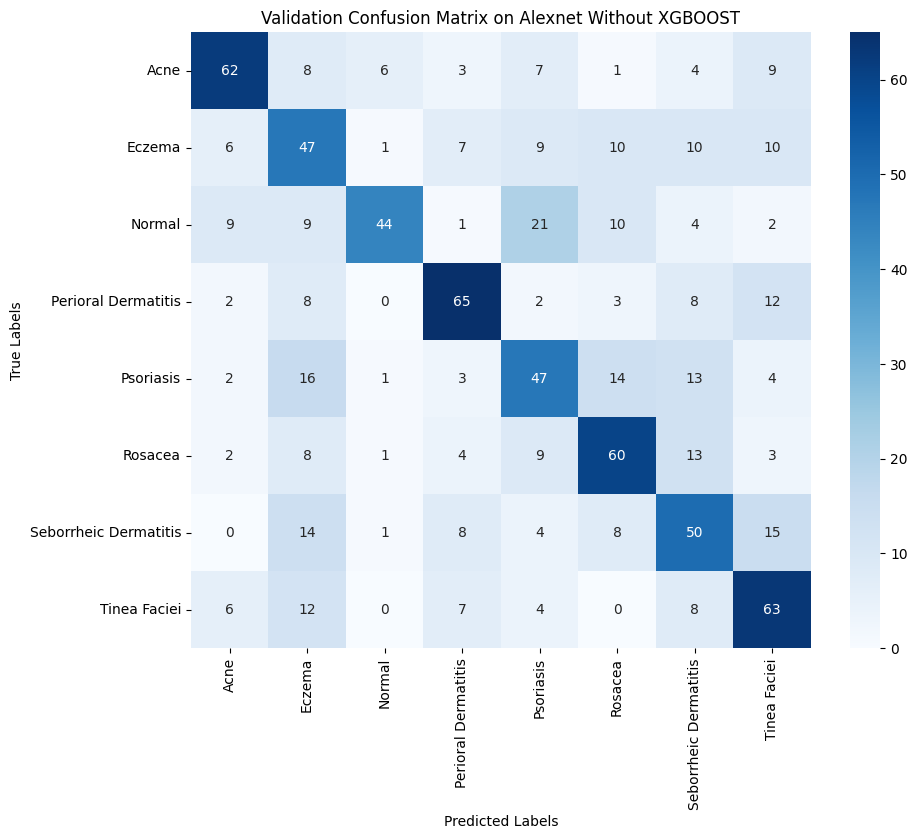

In [7]:
evaluate_model(model, val_loader, device, class_names, "Validation")

Evaluating Test Set: 100%|██████████| 400/400 [00:05<00:00, 72.24it/s]



Test Accuracy: 53.25%

Test Classification Report:

                       precision    recall  f1-score   support

                 Acne       0.69      0.62      0.65        50
               Eczema       0.35      0.38      0.36        50
               Normal       0.77      0.54      0.64        50
  Perioral Dermatitis       0.55      0.62      0.58        50
            Psoriasis       0.42      0.40      0.41        50
              Rosacea       0.57      0.64      0.60        50
Seborrheic Dermatitis       0.50      0.58      0.54        50
         Tinea Faciei       0.51      0.48      0.49        50

             accuracy                           0.53       400
            macro avg       0.54      0.53      0.53       400
         weighted avg       0.54      0.53      0.53       400



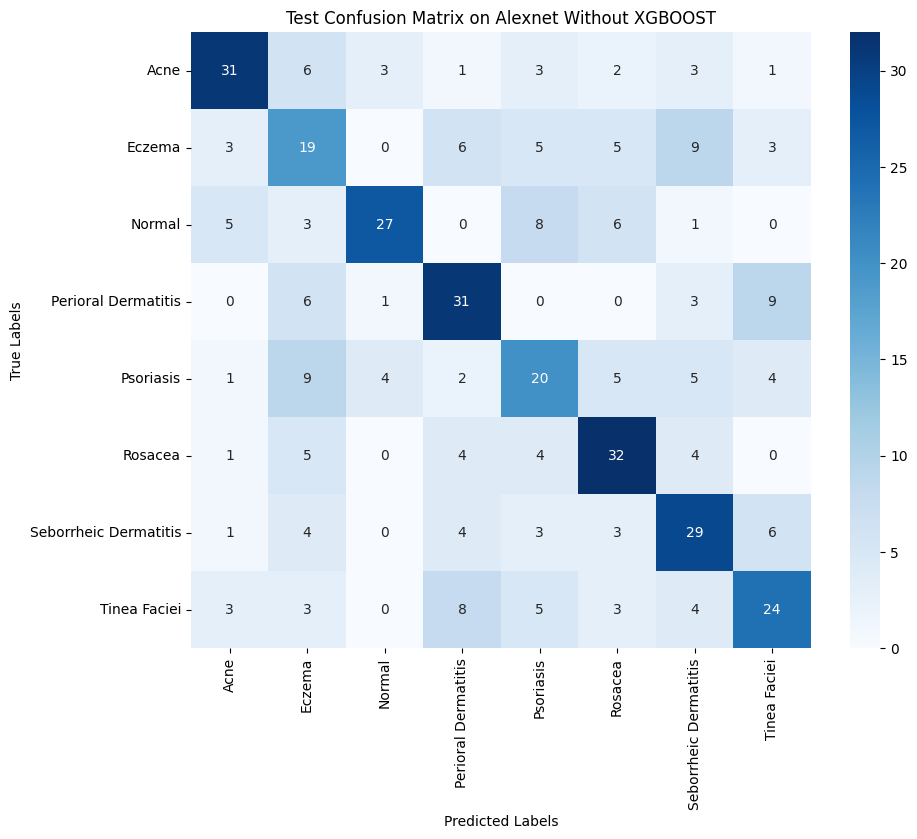

Predictions saved to Test_alexnet_predictions.txt


In [8]:
evaluate_model(model, test_loader, device, class_names, "Test", export_txt=True)